In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob, time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from utils import get_hog_features

%matplotlib inline

## Feature Extraction Function

In [2]:
color_reps = {'HSV':cv2.COLOR_BGR2HSV, 
              'LUV': cv2.COLOR_BGR2LUV, 'HLS':cv2.COLOR_BGR2HLS, 
              'YUV': cv2.COLOR_BGR2YUV, 'YCrCb': cv2.COLOR_BGR2YCrCb}

In [12]:
def extract_img_features(img, channel='All', 
                         hog_feat=True, orient=9, pix_per_cell=8, cell_per_block=2, 
                         spatial_feat=True, spatial_size=(16,16), 
                         hist_feat=True, hist_bins=32):
    
    hog_features = np.array([])
    if hog_feat:
        if channel=='All':
            hog_feat1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True)
            hog_feat2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True)
            hog_feat3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True)
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        else:
            hog_features = get_hog_features(img[:,:,channel], orient, 
                                       pix_per_cell, cell_per_block, 
                                       vis=False, feature_vec=True)
            
    hist_features = np.array([])        
    if hist_feat:
        ch1 = np.histogram(img[:,:,0], bins=hist_bins, range=(0, 256))[0]
        ch2 = np.histogram(img[:,:,1], bins=hist_bins, range=(0, 256))[0]
        ch3 = np.histogram(img[:,:,2], bins=hist_bins, range=(0, 256))[0]
        hist_features = np.hstack((ch1, ch2, ch3))
        
    spatial_features = np.array([]) 
    if spatial_feat:
        spatial_features = cv2.resize(img, spatial_size).ravel()
        
    return np.hstack((hog_features, hist_features, spatial_features)).reshape(1,-1)


## Load Model

In [4]:
model_pickle = pickle.load( open("model_HSV_all_features.pkl", "rb" ) )
svc = model_pickle["svc"]
X_scaler = model_pickle["scaler"]
orient = model_pickle["orient"]
pix_per_cell = model_pickle["pix_per_cell"]
cell_per_block = model_pickle["cell_per_block"]
spatial_size = model_pickle["spatial_size"]
hist_bins = model_pickle["hist_bins"]

## Slide window

In [5]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Takes in an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [6]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', channel='All',
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        if color_space in color_reps:
            test_img = cv2.cvtColor(test_img, color_reps[color_space])
        features = extract_img_features(test_img, channel=channel, 
                                        spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Demostrate Searching Region

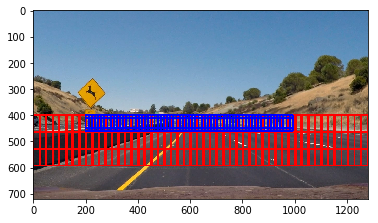

In [7]:
image = cv2.imread('test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                        xy_window=(128, 128), xy_overlap=(0.8, 0.5))
    
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
windows = slide_window(image, x_start_stop=[200, 1000], y_start_stop=[400, 470], 
                        xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)
plt.figure()
plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))

In [8]:
def get_boxes(image, svc, X_scaler, color_space, spatial_feat=True, hist_feat= True):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.5))
    windows += slide_window(image, x_start_stop=[200, 1000], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat))
    return hot_windows

/Users/dxw060/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6.42 Seconds to process test images


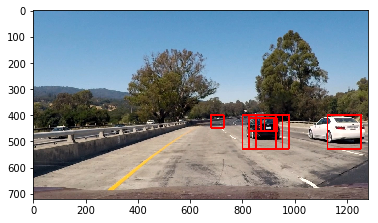

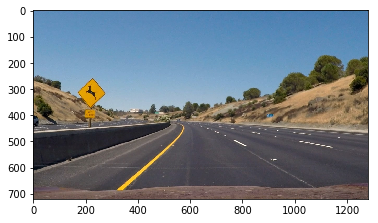

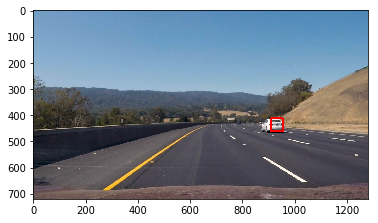

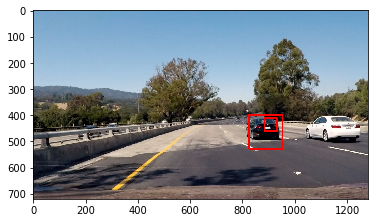

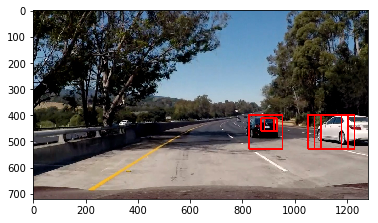

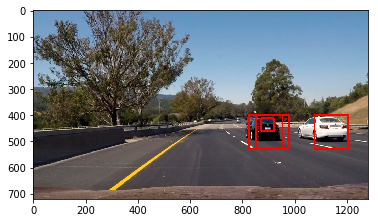

In [26]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    
    hot_windows = get_boxes(image, svc, X_scaler, color_space='HSV', spatial_feat=True, hist_feat= True)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
    plt.savefig('output_images/'+image_p.split('/')[-1])

print(round(time.time()-t, 2), 'Seconds to process test images')

/Users/dxw060/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


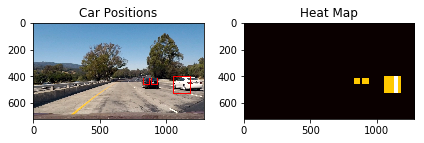

In [14]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Read in image similar to one shown above 
image = cv2.imread('test_images/test1.jpg')

hot_windows = get_boxes(image, svc, X_scaler, color_space='HLS')                       
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Hog Sub-sampling

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_car_boxes(img, ystart, ystop, scale, 
              svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            ch1 = np.histogram(subimg[:,:,0], bins=hist_bins, range=(0, 256))[0]
            ch2 = np.histogram(subimg[:,:,1], bins=hist_bins, range=(0, 256))[0]
            ch3 = np.histogram(subimg[:,:,2], bins=hist_bins, range=(0, 256))[0]
            hist_features = np.hstack((ch1, ch2, ch3))
          
            # Get color features
            spatial_features = cv2.resize(subimg, spatial_size).ravel()
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, hist_features, 
                                                          spatial_features)).reshape(1,-1))    
#             test_features = X_scaler.transform(hog_features)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return windows

/Users/dxw060/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2.58 Seconds to process test images


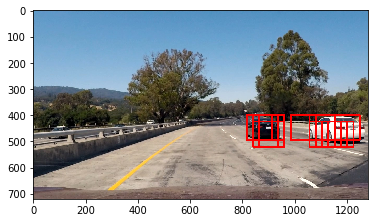

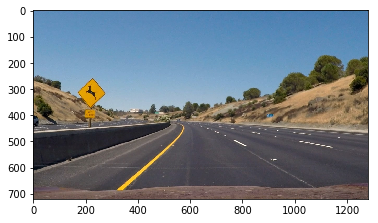

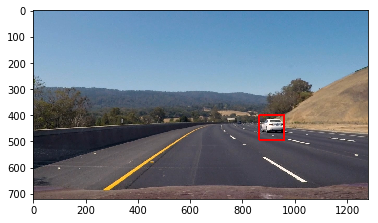

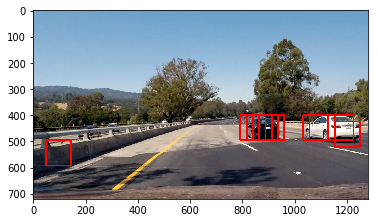

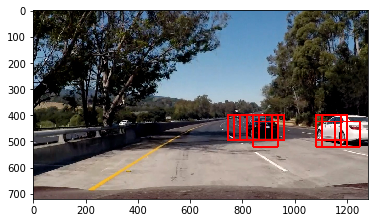

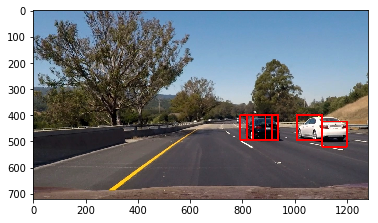

In [20]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_img = image.copy()
    windows = find_car_boxes(image, 400, 656, 1.5, 
                        svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins)
    for w in windows:
        cv2.rectangle(draw_img,w[0],w[1],(0,0,255),6) 

    plt.figure()
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

print(round(time.time()-t, 2), 'Seconds to process test images')

/Users/dxw060/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


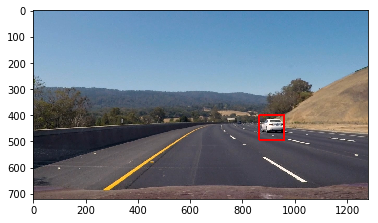

In [22]:
image = cv2.imread('test_images/test3.jpg')
    
orient=9
pix_per_cell=8
cell_per_block=2
spatial_size=(16,16)
hist_bins=32
    
draw_img = image.copy()
windows = find_car_boxes(image, 400, 656, 1.5, 
                    svc, X_scaler, 
                    orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins)
for w in windows:
    cv2.rectangle(draw_img,w[0],w[1],(0,0,255),6) 

plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

/Users/dxw060/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3.75 Seconds to process test images


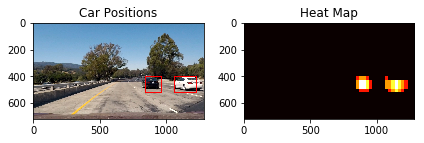

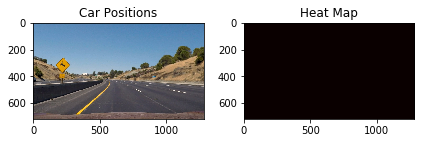

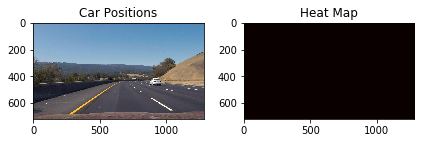

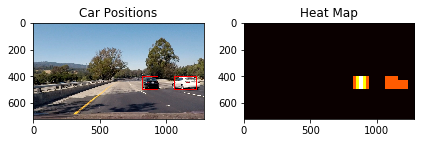

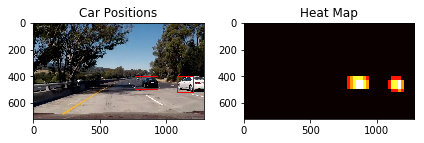

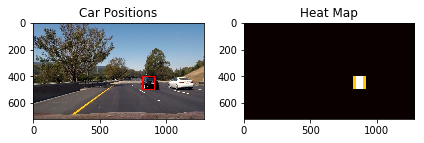

In [27]:
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    hot_windows = find_car_boxes(image, 400, 656, 1.5, 
                                svc, X_scaler, 
                                orient, pix_per_cell, cell_per_block, 
                                spatial_size, hist_bins)                    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.savefig('output_images/heat_'+image_p.split('/')[-1])

print(round(time.time()-t, 2), 'Seconds to process test images')

/Users/dxw060/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


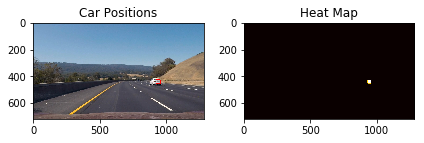

In [24]:
image = cv2.imread('test_images/test3.jpg')
    
hot_windows = find_car_boxes(image, 400, 464, 0.5, 
                            svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, 
                            spatial_size, hist_bins)                    
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()